In [1]:
import torch

In [13]:
inputs = torch.tensor([1, 0, 0, 1]).reshape((2,2)).to(torch.float32)
a = torch.tensor([[1.3428, 2.123], [2.123123, 2.123]], dtype=torch.float32)

In [14]:
a

tensor([[1.3428, 2.1230],
        [2.1231, 2.1230]])

In [15]:
inputs@a

tensor([[1.3428, 2.1230],
        [2.1231, 2.1230]])

In [29]:
# let me do one bit quantization (2 f32 values)
# 1. create a fake codebook
codebook = torch.tensor([1.3428, 2.123]).to(torch.float32)

In [30]:
a_codified = torch.tensor([[0, 1], [1, 1]], dtype=torch.uint8)

In [31]:
a_codified

tensor([[0, 1],
        [1, 1]], dtype=torch.uint8)

In [32]:
reconstruction = torch.zeros_like(a_codified, dtype=torch.float32)

In [33]:
# I want to reconstruct a with the codebook and the codified
reconstruction[a_codified == 0] = codebook[0]
reconstruction[a_codified == 1] = codebook[1]

In [34]:
reconstruction

tensor([[1.3428, 2.1230],
        [2.1230, 2.1230]])

In [35]:
reconstruction

tensor([[1.3428, 2.1230],
        [2.1230, 2.1230]])

In [38]:
e = torch.nn.Embedding(2, 2)

In [43]:
print(e(torch.tensor(0)))
print(e(torch.tensor(1)))

tensor([-0.2070,  0.5983], grad_fn=<EmbeddingBackward0>)
tensor([1.5004, 1.4408], grad_fn=<EmbeddingBackward0>)


In [44]:
def index_codebook(weight_matrix, codebook):
	new_weights = torch.zeros_like(weight_matrix).to(torch.float32)
	for i in range(len(codebook)):
		new_weights[weight_matrix == i] = codebook[i]
	return new_weights

In [45]:
reconstruction = index_codebook(a_codified, codebook)

In [68]:
import torch

# Define your integer matrix
integer_matrix = torch.tensor([0, 1, 1, 1]).reshape(2,2)

# Define your codebook tensor
codebook = torch.tensor([1.3428, 2.123]).to(torch.float32)

# Use the integer matrix as indices to retrieve values from the codebook
result_matrix = codebook[integer_matrix]

print(result_matrix)

tensor([[1.3428, 2.1230],
        [2.1230, 2.1230]])


In [69]:
from sklearn.cluster import KMeans

# def k_means_quantization(image_ndarray: np.ndarray, k=2):
# 	H, W, C = image_ndarray.shape
# 	colors, labels = k_means(image_ndarray.reshape(-1, C), k)
# 	quantized_image = assign_colors(labels, colors, k).reshape(H, W, C)
# 	return Image.fromarray(quantized_image.astype(np.uint8))
def k_means(X, k=2):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    return kmeans.cluster_centers_, kmeans.labels_

def quantize(weights, k=2):
    # 1. apply k means clustering to the weights in a linear fashion
    # 2. take the values and put them in the codebook
    centroids, labels = k_means(weights.reshape(-1, 1), k)
    codebook = torch.tensor(centroids, dtype=torch.float32)
    new_weights = torch.tensor(labels, dtype=torch.uint8).reshape(weights.shape)
    return codebook, new_weights

In [70]:
a = torch.randn(200, 200)
c, w = quantize(a, k=8)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [83]:
%%timeit
index_codebook(w, c)

774 µs ± 49.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [84]:
%%timeit
c.reshape(-1)[w.to(torch.int)]

118 µs ± 8.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [85]:
# but 4 times larger

In [109]:
def weight_dist(int_weights):
	import pandas as pd
	df = pd.DataFrame({"weights": int_weights.reshape(-1).tolist()})
	return df.hist()

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


tensor(0.0348)


array([[<Axes: title={'center': 'weights'}>]], dtype=object)

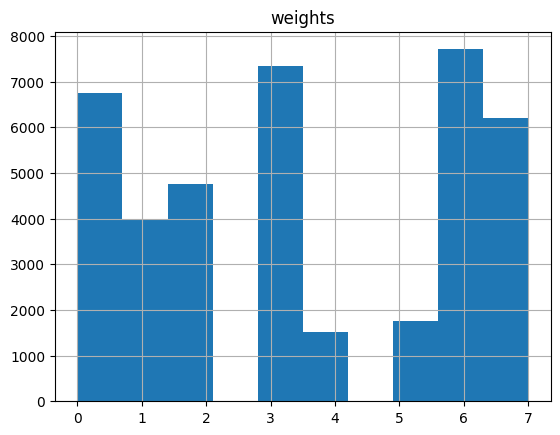

In [121]:
# not bad squared error!
a = torch.randn(200, 200)
c, w = quantize(a, k=8)
print(((a - index_codebook(w, c))**2).mean())
weight_dist(w)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


tensor(0.0002)


array([[<Axes: title={'center': 'weights'}>]], dtype=object)

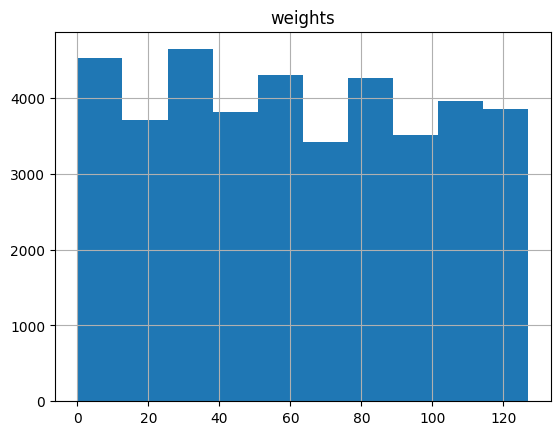

In [120]:
c, w = quantize(a, k=128)
print(((a - index_codebook(w, c))**2).mean())
weight_dist(w)

/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


tensor(0.0026)


array([[<Axes: title={'center': 'weights'}>]], dtype=object)

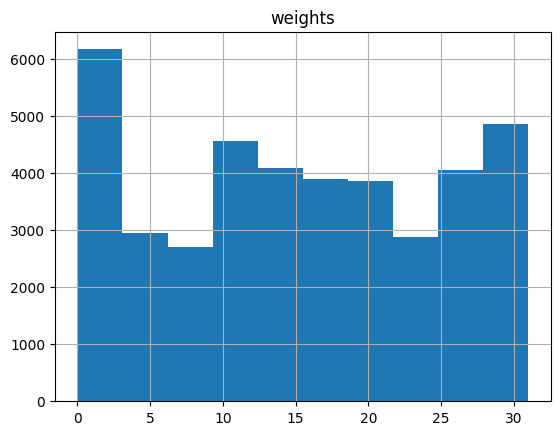

In [123]:
bits = 5
c, w = quantize(a, k=int(2**bits))
print(((a - index_codebook(w, c))**2).mean())
weight_dist(w)